In [232]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes

In [233]:
start = datetime.datetime(2009,1,1)
end = datetime.datetime(2022,1,21)
windows = [15,30,45,60]

In [234]:
from ipynb.fs.full.Data_Processing import *

gold = get_data(start,end,windows)


DOWNLOADING THE DATA FROM YAHOO FINANCE ....
[*********************100%***********************]  1 of 1 completed
ADDING TECHNICAL INDICATORS ...
SELECTING THE BEST FEATURES ....


In [235]:
gold.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,932.500000,908.599976,924.599976,938.973330,930.335552,909.468330,915.500000
2009-03-31,924.500000,911.599976,918.000000,937.493329,930.648885,910.198330,922.599976
2009-04-01,932.500000,916.900024,918.599976,935.773328,931.246662,911.346662,926.099976
2009-04-02,930.299988,894.900024,926.900024,933.483329,931.675552,912.046662,907.400024
2009-04-03,910.299988,891.299988,904.599976,929.943329,931.464441,912.954996,895.599976


In [236]:
## Differencing the data for 
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [237]:
def get_flattened(data,window_size):
    X,Y = [],[]
    for i in range(0,len(data)-window_size):
        X.append(data.iloc[i:i+window_size,:].T.to_numpy().flatten())
        Y.append(data.Close[i+window_size])
    return np.array(X),np.array(Y)

In [238]:
def get_unflattened(data,window_size):
    X,Y = [],[]
    for i in range(0,len(data)-window_size):
        X.append(data.iloc[i:i+window_size,:])
        Y.append(data.Close[i+window_size])
    return np.array(X),np.array(Y)

In [389]:
final_data = gold.copy()

## Scaling the data

In [390]:
from sklearn.preprocessing import MinMaxScaler as mms

In [391]:
input_scaler = mms(feature_range=(-1,1))
selected_features = final_data.columns[0:6]
print(selected_features)


Index(['High', 'Low', 'Open', 'SMA_30', 'SMA_45', 'SMA_60'], dtype='object')


In [392]:
final_data[selected_features] = input_scaler.fit_transform(final_data[selected_features])

In [393]:
final_data.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,-0.904321,-0.925787,-0.905159,-0.922184,-0.955397,-1.000000,915.500000
2009-03-31,-0.917797,-0.920681,-0.916376,-0.924972,-0.954794,-0.998576,922.599976
2009-04-01,-0.904321,-0.911660,-0.915357,-0.928212,-0.953645,-0.996336,926.099976
2009-04-02,-0.908027,-0.949106,-0.901249,-0.932526,-0.952820,-0.994971,907.400024
2009-04-03,-0.941717,-0.955234,-0.939152,-0.939194,-0.953226,-0.993199,895.599976


In [394]:
output_scaler = mms(feature_range=(-1,1))
final_data.Close = output_scaler.fit_transform(final_data.Close.to_numpy().reshape(-1, 1))
final_data.head()

,High,Low,Open,SMA_30,SMA_45,SMA_60,Close
Date,,,,,,,
2009-03-30,-0.904321,-0.925787,-0.905159,-0.922184,-0.955397,-1.000000,-0.918757
2009-03-31,-0.917797,-0.920681,-0.916376,-0.924972,-0.954794,-0.998576,-0.906765
2009-04-01,-0.904321,-0.911660,-0.915357,-0.928212,-0.953645,-0.996336,-0.900853
2009-04-02,-0.908027,-0.949106,-0.901249,-0.932526,-0.952820,-0.994971,-0.932438
2009-04-03,-0.941717,-0.955234,-0.939152,-0.939194,-0.953226,-0.993199,-0.952369


In [395]:
## Shift the close column by 1
#final_data["Close"] = final_data.Close.shift(-1)
#final_data = final_data.dropna()
#final_data.head()

In [396]:
x,y = get_unflattened(final_data,5)

In [397]:
x.shape,y.shape

((3220, 5, 7), (3220,))

In [398]:
final_data.shape

(3225, 7)

### Models

In [399]:
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import keras
import tensorflow as tf

In [860]:
n = len(x)
X_train = x[0:int(n*0.7)]
X_val = x[int(n*0.7):int(n*0.9)]
X_test = x[int(n*0.9):]


Y_train = y[0:int(n*0.7)]
Y_val = y[int(n*0.7):int(n*0.9)]
Y_test = y[int(n*0.9):]

In [861]:
X_train.shape


(2254, 5, 7)

In [862]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units = 90,
                       return_sequences=True,
                       batch_input_shape=(None, X_train.shape[1],X_train.shape[2])), # [None,60,1] #[batch, time steps, dimension]
    
    tf.keras.layers.LSTM(units = 60,
                       return_sequences=True),
    
    tf.keras.layers.LSTM(units = 40,
                       return_sequences=False),
    
  tf.keras.layers.Dense(1),
])
print(model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0006)

model.compile(loss = "mse",
              metrics ="mae",
              optimizer = optimizer)

print(model.summary())

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="mae",
    patience=4,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    verbose=0,
                    epochs=400,callbacks=[callbacks])

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_158 (LSTM)              (None, 5, 90)             35280     
_________________________________________________________________
lstm_159 (LSTM)              (None, 5, 60)             36240     
_________________________________________________________________
lstm_160 (LSTM)              (None, 40)                16160     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 41        
Total params: 87,721
Trainable params: 87,721
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_158 (LSTM)              (None, 5, 90)             35280     
_____________________

In [863]:
def plot_time_series(Y_test,test_predictions):
    plt.figure(figsize=(13, 8))
    plt.plot(Y_test, marker='.')
    plt.plot(test_predictions,marker='+', c='orange')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(["True Value","$\hat{y}$"])
    plt.show()

In [864]:
test_predictions = model.predict(X_test) 

In [865]:
test_predictions = output_scaler.inverse_transform(test_predictions.flatten().reshape(-1, 1))
test_predictions = test_predictions.flatten()

In [866]:
Y_test = output_scaler.inverse_transform(Y_test.flatten().reshape(-1, 1))

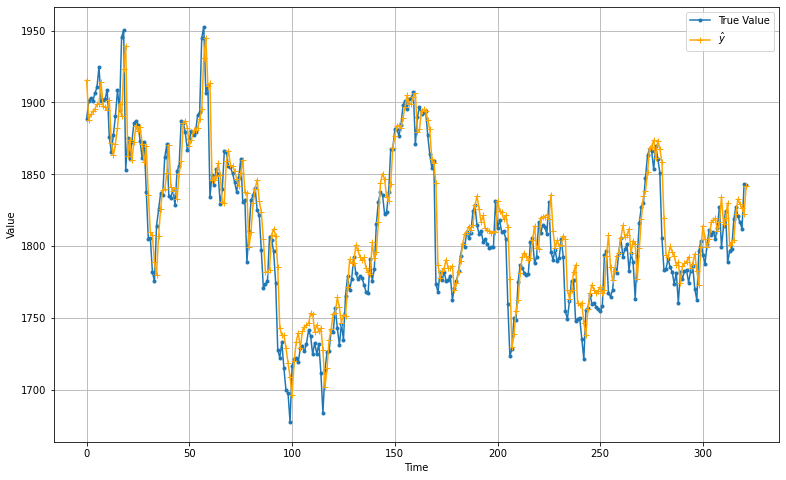

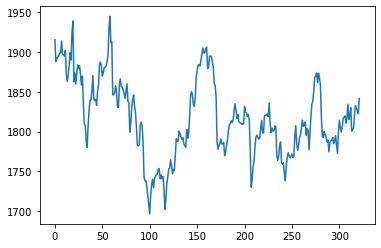

In [867]:
plot_time_series(Y_test,test_predictions)
plt.plot(test_predictions)
plt.show()

In [868]:
from sklearn.metrics import mean_absolute_error as mae
print(mae(Y_test,test_predictions))

14.133978233574343


In [869]:
error = Y_test.flatten()-test_predictions.flatten()

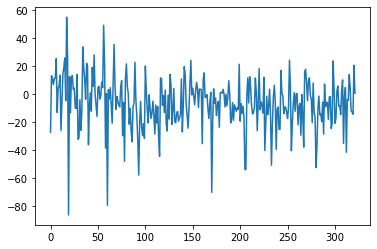

In [871]:
plt.plot(error)
plt.show()